In [154]:
#script to read in .csv output files from SmartRoot analysis, concatenate them and then analyse and make plots
#use qPCR conda environment

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob 
import sys
import argparse
import statsmodels.api as sm

import statsmodels.formula.api as smf
from bioinfokit.analys import stat

In [156]:
# #define arguments
# parser = argparse.ArgumentParser(description='Analyse SmartRoot output')
# parser.add_argument('-i', '--input', help='input directory', required=True)
# parser.add_argument('-o', '--output', help='output directory', required=True)





In [157]:
#function to recursively find all .csv files in a directory and concatenate them into a single dataframe
def concat_csv_recursive(PATH, EXT):
    #find all .csv files in the directory
    csv_files = [file for path, subdir, fname in os.walk(PATH) 
                for file in glob.glob(os.path.join(path, EXT))]
        #glob.glob(f'{directory}/{EXT}', recursive=True)
    #print(csv_files)
    #initialise empty dataframe
    df = pd.DataFrame()
    #loop through all files and concatenate them into a single dataframe
    for file in csv_files:
        df = pd.concat([df, pd.read_csv(file)], ignore_index=True)
    return df

In [158]:
def sort_data(df,output_location):
    #sort dataframe by sample name
    df = df.sort_values(by=['image'])
    #remove duplicate rows
    df = df.drop_duplicates(keep='first')
    #make nitrate concentration column using image column
    df['nitrate_concentration'] = df['image'].str.split('_').str[1]
    #make sample name column using image column
    df['sample_name'] = df['image'].str.split('_').str[0]
    #make plate column
    df['plate'] = df['sample_name']+'_'+df['image'].str.split('_').str[2]
    #remove spaces from column names
    df.columns = df.columns.str.replace(' ', '')
   
    
    #make several new columns
    #first make new df which will contain one row per plant
    df_plant = df[df.root_order == 0]
    #remove all lines which have no length or which are NaN
    df_plant = df_plant[df_plant.length.notnull()]
    #df_plant = df_plant[df_plant.length != 0]
    # df_plant = df.groupby(['sample_name', 'plate', 'nitrate_concentration',root_ontology]).agg({'image':'count', 'nitrate_concentration':'first', 'sample_name':'first', 'plate':'first'})
    #print(df_plant)
    ## PR = primary root length (cm)
    #change length column to PR
    df_plant['PR'] = df_plant['length']
    # LR = lateral root number (visible from scan)
    #for each root in df_plant, count the number of rows whose parent root in df is the same as the root id in df_plant
    df_plant['LR'] = df_plant.apply(lambda row: df[(df.parent == row.root) & (df.root_order == 1)].shape[0], axis=1)
    #make list of first order lateral root ids
    df_plant['LR_ids'] = df_plant.apply(lambda row: df[(df.parent == row.root) & (df.root_order == 1)].root.tolist(), axis=1)
    #for each id in LR_ids, count the number of rows whose parent root in df is the same as the root id 
    df_plant['LR_2nd_order'] = df_plant.apply(lambda row: df[(df.parent.isin(row.LR_ids)) & (df.root_order == 2)].shape[0], axis=1)
    # LRL = total lateral root length (all LRs added together - cm). Have separate column for 2nd order lateral roots
    df_plant['LRL'] = df_plant.apply(lambda row: df[(df.parent == row.root) & (df.root_order == 1)].length.sum(), axis=1)
    df_plant['LRL_2nd_order'] = df_plant.apply(lambda row: df[(df.parent.isin(row.LR_ids)) & (df.root_order == 2)].length.sum(), axis=1)
    # ALRL = average lateral root length (LRL/LR - cm)
    df_plant['ALRL'] = (df_plant.LRL + df_plant.LRL_2nd_order) / (df_plant.LR + df_plant.LR_2nd_order)
   # df_plant['ALRL'] = df_plant.apply(lambda row: (row.LRL / row.LR, axis=1)
    # TRL = total root length (PR + LRL)
    df_plant['TRL'] = df_plant.PR + df_plant.LRL + df_plant.LRL_2nd_order
    # LRD = lateral root density (LR/PR)
    df_plant['LRD'] = df_plant.LR / df_plant.PR
    # LRL_div_TRL = percentage of LRL contributing to TRL (LRL/TRL)
    df_plant['LRL_div_TRL'] = (df_plant.LRL + df_plant.LRL_2nd_order) / df_plant.TRL

    #add genotype column
    df_plant['genotype'] = df_plant['root_name'].str.split('_').str[0]

    #add log columns for PR, LR, LR_2nd_order, LRL, LRL_2nd_order. ALRL, TRL, LRD, LRL_div_TRL
    df_plant['log_PR'] = np.log(df_plant.PR)
    df_plant['log_LR'] = np.log(df_plant.LR)
    df_plant['log_LR_2nd_order'] = np.log(df_plant.LR_2nd_order)
    df_plant['log_LRL'] = np.log(df_plant.LRL)
    df_plant['log_LRL_2nd_order'] = np.log(df_plant.LRL_2nd_order)
    df_plant['log_ALRL'] = np.log(df_plant.ALRL)
    df_plant['log_TRL'] = np.log(df_plant.TRL)
    df_plant['log_LRD'] = np.log(df_plant.LRD)
    df_plant['log_LRL_div_TRL'] = np.log(df_plant.LRL_div_TRL)
    






    #save df as tsv file
    df_plant.to_csv(f'{output_location}/single_plant_data.tsv', sep='\t', index=False)
    #count number of plants for each plant line

    #partition variation across mutants relative to wild type using principal component analysis of all RSA traits
    #do stats: Using a two-way ANOVA, three phenotypic categories: genotype effects in both nitrogen conditions (genotype-dependent), genotype effects in only one condition (nitrogen-condition-dependent) or genotype by nitrogen condition-dependent effects 
    

    #print(len(df))
    return df, df_plant

In [159]:
#function to analyse data and make plots
def analyse_data(df_plant, output_location):
    """function to run anovas and make boxplots"""
    #anova_PR <- lm(logPR ~ Genotype*NO3_Level + Plate, data = Roots1)
    #change -inf values to NaN
    df_plant['log_PR'] = df_plant['log_PR'].replace(-np.inf, np.nan)
    df_plant['log_LR'] = df_plant['log_LR'].replace(-np.inf, np.nan)
    df_plant['log_LRL'] = df_plant['log_LRL'].replace(-np.inf, np.nan)
    df_plant['log_ALRL'] = df_plant['log_ALRL'].replace(-np.inf, np.nan)
    df_plant['log_TRL'] = df_plant['log_TRL'].replace(-np.inf, np.nan)
    df_plant['log_LRD'] = df_plant['log_LRD'].replace(-np.inf, np.nan)
    df_plant['log_LRL_div_TRL'] = df_plant['log_LRL_div_TRL'].replace(-np.inf, np.nan)
    df_plant['log_LR_2nd_order'] = df_plant['log_LR_2nd_order'].replace(-np.inf, np.nan)
    df_plant['log_LRL_2nd_order'] = df_plant['log_LRL_2nd_order'].replace(-np.inf, np.nan)
    

    anova_PR = smf.ols('log_LRL ~ genotype*nitrate_concentration + plate', data=df_plant).fit()
    #check anova assumptions
    print(anova_PR.summary())
    fig = sm.qqplot(anova_PR.resid, line='s')
    #not normal so take log of each value


    # ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)

    # res = stat()
    # res.anova_stat(df=df_plant, res_var='PR', anova_model='PR ~ genotype*nitrate_concentration + plate')
    # res.anova_summary
    # #generate QQ-plot from standardized residuals
    # # res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
    # # sm.qqplot(res.anova_std_residuals, line='45')
    # # plt.xlabel("Theoretical Quantiles")
    # # plt.ylabel("Standardized Residuals")
    # # plt.show()
    # res.qq_plot(df=df_plant, res_var='PR', anova_model='PR ~ genotype*nitrate_concentration + plate')
        





In [160]:
#main function
def main(args):
    #read in arguments
    #input_dir = args.input
    input_dir = f'../../data/CRISPR_library/images/rsa_output'
    #output_dir = args.output
    output_dir = f'../../data/CRISPR_library'
    #make directory for the plots to be exported to
    output_dir = f'{output_dir}/smartroot_plots'
    try:
        # Create target Directory
        os.mkdir(output_dir)
        print("Directory " , output_dir ,  " created") 
    except FileExistsError:
        print("Directory " , output_dir ,  " already exists")

    #read in and concatenate .csv files
    df = concat_csv_recursive(input_dir, '*.csv')
    #print(df.head())

    
    #sort data
    df,df_plant = sort_data(df,output_dir)
    #analyse dataframe and make plots
    #analyse_data(output_dir)
    #analyse and make plots
    analyse_data(df_plant, output_dir)
    
    #save dataframe to csv file
    df.to_csv(f'{output_dir}/all_smartroot_data.csv', index=False)

Directory  ../../data/CRISPR_library/smartroot_plots  already exists


/home/witham/opt/anaconda3/envs/qpcr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/witham/opt/anaconda3/envs/qpcr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/witham/opt/anaconda3/envs/qpcr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/witham/opt/anaconda3/envs/qpcr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/witham/opt/anaconda3/envs/qpcr/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

                            OLS Regression Results                            
Dep. Variable:                log_LRL   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     9.989
Date:                Tue, 30 Aug 2022   Prob (F-statistic):           1.98e-28
Time:                        11:28:40   Log-Likelihood:                -436.21
No. Observations:                 357   AIC:                             926.4
Df Residuals:                     330   BIC:                             1031.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

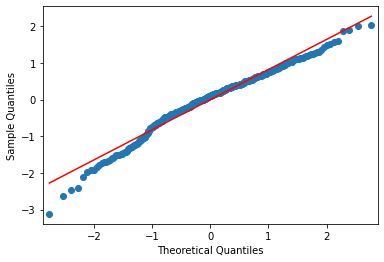

In [161]:
if __name__ == '__main__':
    main(sys.argv)